# Project Inroduction

The dataset used for this project contains data gathered by the New York City Taxi & Limousine Commission. For each trip, there are many different data variables gathered as seen in the dictionary below. The main goal of this project is to build a model that can predict the "total_amount" or final cost of a trip before the trip is taken so that this price may be shown to prospective riders to increase sales since buyers are more likely to buy a service when they know what they are getting. Also it's important to note that for the purposes of this project we are making the assumption that riders enter in the relevant information (Mainly Pickup/Dropoff Location from which many other variables can be derived) prior to booking the ride, the same way you would if you were using UBER for example.

### Data Dictionary / Feature Definitions

**ID**: Trip identification number.

**VendorID**: A code indicating the TPEP provider that provided the record.

        1= Creative Mobile Technologies, LLC;

        2= VeriFone Inc.

**tpep_pickup_datetime**: The date and time when the meter was engaged.

**tpep_dropoff_datetime**: The date and time when the meter was disengaged.

**Passenger_count**: The number of passengers in the vehicle. This is a driver-entered value.

**Trip_distance**: The elapsed trip distance in miles reported by the taximeter.

**PULocationID**: TLC Taxi Zone in which the taximeter was engaged.

**DOLocationID**: TLC Taxi Zone in which the taximeter was disengaged.

**RateCodeID**: The final rate code in effect at the end of the trip.

        1= Standard rate

        2= JFK

        3= Newark

        4= Nassau or Westchester

        5= Negotiated fare

**Store_and_fwd_flag**: This flag indicates whether the trip record was held in vehicle memory before being sent to
                           the vendor, aka “store and forward,” because the vehicle did not have a connection to the
                           server.

        Y= store and forward trip

        N= not a store and forward trip

**Payment_type**: A numeric code signifying how the passenger paid for the trip.

        1= Credit card

        2= Cash

        3= No charge

        4= Dispute

        5= Unknown

        6= Voided trip

**Fare_amount**: The time-and-distance fare calculated by the meter.

**Extra**: Miscellaneous extras and surcharges. Currently, this only includes the $0.50 and $1 rush hour and overnight charges.

**MTA_tax**: $0.50 MTA tax that is automatically triggered based on the metered rate in use.

**Improvement_surcharge**: $0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.

**Tip_amount**: Tip amount - This field is automatically populated for credit card tips. Cash tips are not included.

**Tolls_amount**: Total amount of all tolls paid in trip.

#### _Let's start_ by taking an overview of the features and their importance to the main goal and see if there is any columns that can be premtively dropped so as to not waste time exploring them. (This would obviously be impractical on a dataset with a lot of features however I am including this here due to this being a portfolio project and therefore my thought process may be important to see)

**Trip ID**: This is a statically increasing integer count of trips that I do not believe to even be specific to each vehicle (i.e. each vehicle tracks their own ride numbers) so this feature cannot be used in any way to predict the final cost of the ride.

**Vendor ID**: There are two vendors in this dataset and they may have different rates they charge with thier taxis.

**Pickup Datetime**: These values can be used to analyze if certain times in the day have more or less demand and thus may incur a premuim due the laws of supply/demand. If certain times can be proven to be more expensive then we can use this to predict final cost.

**Dropoff Datetime**: These values would not be avialable when our model is deployed, and although we could make the assumption that we could estimate this time, for the purposes of this project that assumption will not be made.

**Passenger Count**: Since we don't know the ins and outs the policies at these taxi companies, drivers may be permitted to charge a premium based on certain amounts of riders, so this feature will need investigation as it may be useful.

**Trip Distance**: We would expect this to be the one of the features with the highest correlation with the final cost of the ride.

**Pickup/Dropoff Location**: These values can be used to analyze if certain zones have more or less traffic and thus take the taxi driver longer to navigate them making the ride run longer which would increase the final cost of the ride.

**Ratecode**: This variable will need investgation as to how much of an effect it has on the final cost

**Store & Forward Flag**: This variable is not expected to be valueable in predicting the final cost since it only tracks information that is gathed after the ride has taken place.

**Payment Type**: We will need to checkk whether it makes a difference whether a rider pays by cash or card.

**Fare Amount**: Since this feature is made up of other features which will be included in the final model, it is not necessary to include, since it will add undue additional weight to those features comprising it.

**Extra**: This is a varible taken down at rides end and not available beforehand but since it only tracks certain premiums based on the time of day we can make binary columns in the dataset to track it instead.

**MTA Tax**: A nearly perfectly static 50 cent charge applied after the ride ends, its value is included in the final cost already so this column is not necessary.

**Improvement Surcharge**: A static 30 cent charge on every ride, provides no predictive power since it never changes

**Tip Amount**: Since tips are a variable controlled by the rider it can't reliably be predicted in a general sense, and probably not even in a per rider sense, even if we knew who was taking the ride and could remember thier previous tips. We will need to create a new column in the data set that tracks the subtotal of the ride (total_amount without tips) and then try to predict that

**Tolls Amount**: This is another variable we would not have prior to the ride being completed, and since we do not have the data or capabilities within this setting to gather data and route information to estimate what tolls may be paid during the course of the trip, we will have to accept this value being added to the total and remove what variance we can by with the pickup and dropoff locations, since they may correlate with the tolls.

**Total Amount**: As mentioned above we will be creating a new final cost column called subtotal, which is this value with tips subtracted.

##### **In conclusion**, the features we will remove will be ID, Store_and_fwd_flag, Extra, MTA_tax, Improvement_surcharge, Tip_amount, Tolls_amount, Total_amount. But for now we will need to keep all the features the effect the subtotal, since if there are any outliers within them we will not know. And we will keep fare_amount and total_amount should we want them for visualization purposes. So let's load in the data and drop these columns, but first we need to import some modules.

In [178]:
import pandas as pd, seaborn as sns, numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime, date, timedelta

In [179]:
data = pd.read_csv("taxicab_original.csv")

# Create what will be the column we want to predict, subtotal, which is the total_amount - tip_amount, for reasons stated above.
subtotal = data["total_amount"] - data["tip_amount"]

# (purely visual change) Inserts "subtotal" just behind total_amount instead of at the end since it makes more logical sense for it to be here. 
insert_position = len(data.columns) - 1
data.insert(insert_position, "subtotal", subtotal)

# Drop all specified columns
df = data.drop(columns=["Unnamed: 0", "tpep_dropoff_datetime",  "store_and_fwd_flag"])

Now let's examine the data types of our remaining features

In [180]:
df.dtypes

VendorID                   int64
tpep_pickup_datetime      object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
subtotal                 float64
total_amount             float64
dtype: object

We have one column "tpep_pickup_datetime" that is incorrectly encoded as an object, so let's convert it to a datetime obejct.

In [181]:
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])

Since we're here already let's add some columns derived from the pickup time, one for the hour of the pickup (0-23), one for the day of pickup (Mon-Sun), one for the month (Jan-Dec) and one final binary column to account for whether the pickup time was during rush hour (defined here as the hours 6,7,8 & 9 in the morning and 4,5,6, & 7 in the evening, weekends being excluded.) After this we can safely removed the pickup_datetime column since we have all of its important information split into these new columns

In [182]:
hour = df['tpep_pickup_datetime'].dt.hour
day = df['tpep_pickup_datetime'].dt.day_name().str.lower()
month = df['tpep_pickup_datetime'].dt.month_name().str.lower()

df.insert(2, "hour", hour)
df.insert(3, "day", day)
df.insert(4, "month", month)

def is_rush_hour(hour, day):
    return ((6 <= hour < 10) or (16 <= hour < 20)) and ((day != "saturday") and (day != "sunday"))
rush_hour = df.apply(lambda x: 1 if is_rush_hour(x["hour"], x["day"]) else 0, axis = 1)

df.insert(3, "rush_hour", rush_hour)

df = df.drop(columns=["tpep_pickup_datetime"])

Let's make one more new column that will track the $/mi rate of the trip, so that we can compare some of the variables later irrespective of the inevitible influence that trip_distance will have on the data. We will also impute a value of 0 for any rows that have a 0 for trip distance or fare amount.

In [183]:
ride_rate = np.where((df["fare_amount"] > 0) & (df["trip_distance"] > 0), df["fare_amount"] / df["trip_distance"], 0)

# Insert the ride_rate column into the DataFrame at position 6
df.insert(7, "ride_rate", ride_rate)

In [184]:
df.describe()

,VendorID,hour,rush_hour,passenger_count,trip_distance,ride_rate,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,subtotal,total_amount
count,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000
mean,1.556236,13.726552,0.296753,1.642319,2.913313,7.369462,1.043394,162.412353,161.527997,1.336887,13.026629,0.333275,0.497445,1.835781,0.312542,0.299551,14.474721,16.310502
std,0.496838,6.224675,0.456837,1.285231,3.653171,71.809223,0.708391,66.633373,70.139691,0.496211,13.243791,0.463097,0.039465,2.800626,1.399212,0.015673,14.051942,16.097295
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-120.000000,-1.000000,-0.500000,0.000000,0.000000,-0.300000,-120.300000,-120.300000
25%,1.000000,9.000000,0.000000,1.000000,0.990000,4.292387,1.000000,114.000000,112.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,7.800000,8.750000
50%,2.000000,14.000000,0.000000,1.000000,1.610000,5.500000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.350000,0.000000,0.300000,10.300000,11.800000
75%,2.000000,19.000000,1.000000,2.000000,3.060000,7.051282,1.000000,233.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.450000,0.000000,0.300000,15.800000,17.800000
max,2.000000,23.000000,1.000000,6.000000,33.960000,5200.000000,99.000000,265.000000,265.000000,4.000000,999.990000,4.500000,0.500000,200.000000,19.100000,0.300000,1000.290000,1200.290000


As we see from this call to describe() all of our changes were successfully applied, we dropped 8 columns and added 5 new ones. Now let's take a closer look at our remaining features and remove or impute any outliers. We can see we have some erros to fix. We have at least one negative value for fare_amount, and that means someone is being paid to take a taxi ride, which doesn't make sense so we will look at the cost of removing the rows with negative values, otherwise we will imput a value of 0 or the average value for fare_amount. We have similar errors with the columns RatecodeID, extra, mta_tax, and improvement_surcharge (also subtotal and total_amount but this is only a result of the errors in the other columns) <br><br> We also notice some outliers in some of our columns, we have a value of 999.99 in fare_amount, 200.00 in tip_amount and the value of 33.96 for trip_distance may be an outlier so we will have to check.

In [185]:
df["RatecodeID"].value_counts()

RatecodeID
1     22070
2       513
5        68
3        39
4         8
99        1
Name: count, dtype: int64

This error in RatecodeID only occurs once, so we are safe to remove it

In [186]:
df = df[df["RatecodeID"] <= 5]

Lets print out how many negative values are within each of the fiscal columns and evaluate how much of an effect it will have on the dataset to remove them.

In [187]:
print(df[df["fare_amount"] < 0]["fare_amount"].value_counts())
print()
print(df[df["extra"] < 0]["extra"].value_counts())
print()
print(df[df["mta_tax"] < 0]["mta_tax"].value_counts())
print()
print(df[df["tip_amount"] < 0]["tip_amount"].value_counts())
print()
print(df[df["improvement_surcharge"] < 0]["improvement_surcharge"].value_counts())

# df[df["fare_amount"] < 0].head(10)
# df.loc[df['fare_amount'] < 0, 'fare_amount'] = 0
# print(df['fare_amount'].min())

fare_amount
-2.5      4
-3.5      3
-3.0      2
-4.5      2
-4.0      2
-120.0    1
Name: count, dtype: int64

extra
-0.5    7
-1.0    2
Name: count, dtype: int64

mta_tax
-0.5    13
Name: count, dtype: int64

Series([], Name: count, dtype: int64)

improvement_surcharge
-0.3    14
Name: count, dtype: int64


So even if we assume all of the rows in this list to be perfectly mutually exclusive it still only amounts to 59 rows, and since there is around 23,000 rows in the dataset this is far less than 2% so removing all of these rows should not effect the final predictions too greatly. So if we assume these are values to be logically incorrect and likely the result of a typo during input, we are safe to remove them.

In [188]:
mask = (
    (df["fare_amount"] < 0) |
    (df["extra"] < 0) |
    (df["mta_tax"] < 0) |
    (df["tip_amount"] < 0) |
    (df["improvement_surcharge"] < 0)
)

rows_before = df.shape[0]
# Use the mask to select rows that do not meet the condition and update the DataFrame
df = df[~mask]
rows_after = df.shape[0]
print(f'Rows before: {rows_before}\nRows after: {rows_after}\nNumber of rows removed: {rows_before-rows_after}')

Rows before: 22698
Rows after: 22684
Number of rows removed: 14


Only 14 rows we're removed, even better than expected! Now let's take a look at some outliers in our dataset and see what can be done about them

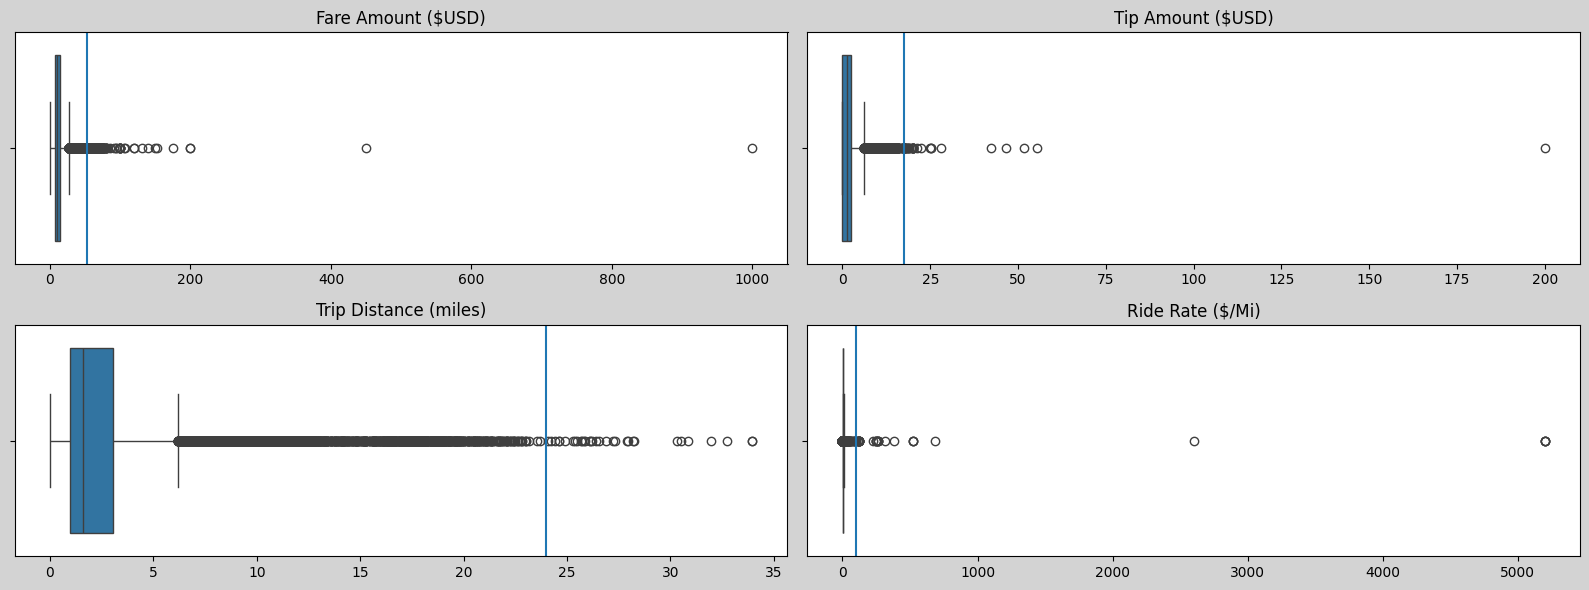

Upper (outlier) bound for Fare Amount: 26.5 (IQR): 8.0
Upper (outlier) bound for Tip Amount: 6.125 (IQR): 2.45
Upper (outlier) bound for Trip Distance: 6.19 (IQR): 2.08
Upper (outlier) bound for Ride Rate: 11.18 (IQR): 2.75


In [189]:
plt.figure(figsize=(16, 6))
plt.gcf().set_facecolor('lightgrey')


plt.subplot(2,2,1)
sns.boxplot(data=df["fare_amount"], orient="h")
plt.title('Fare Amount ($USD)')
plt.xlabel('')
plt.axvline(x = 52.5)

plt.subplot(2,2,2)
sns.boxplot(data=df["tip_amount"] , orient="h")
plt.title('Tip Amount ($USD)')
plt.xlabel('')
plt.axvline(x = 17.5)

plt.subplot(2, 2, 3)
sns.boxplot(data=df["trip_distance"] , orient="h")
plt.title('Trip Distance (miles)')
plt.xlabel('')
plt.axvline(x = 24)

plt.subplot(2, 2, 4)
sns.boxplot(data=df["ride_rate"] , orient="h")
plt.title('Ride Rate ($/Mi)')
plt.xlabel('')
plt.axvline(x = 100)

plt.tight_layout()
plt.show()

iqr_fare = np.quantile(df["fare_amount"], 0.75) - np.quantile(df["fare_amount"], 0.25)
iqr_tip = np.quantile(df["tip_amount"], 0.75) - np.quantile(df["tip_amount"], 0.25)
iqr_distance = np.quantile(df["trip_distance"], 0.75) - np.quantile(df["trip_distance"], 0.25)
iqr_rate = np.quantile(df["ride_rate"], 0.75) - np.quantile(df["ride_rate"], 0.25)
print(f'Upper (outlier) bound for Fare Amount: {np.quantile(df["fare_amount"], 0.75) + 1.5*iqr_fare} (IQR): {iqr_fare}')
print(f'Upper (outlier) bound for Tip Amount: {np.quantile(df["tip_amount"], 0.75) + 1.5*iqr_tip} (IQR): {iqr_tip}')
print(f'Upper (outlier) bound for Trip Distance: {round((np.quantile(df["trip_distance"], 0.75) + 1.5*iqr_distance),2)} (IQR): {round(iqr_distance,2)}')
print(f'Upper (outlier) bound for Ride Rate: {round((np.quantile(df["ride_rate"], 0.75) + 1.5*iqr_rate),2)} (IQR): {round(iqr_rate,2)}')

The oulier upperbounds for **fare_amount, tip_amount and trip_distance** are 26.5, 6.125 and 6.19 respectively, All of with are intuitvely low, since even for some range above this bound, the values are likely from longer rides and therefore warranted and logical data that should not be removed. So let's set our outlier bound to Q3 + 6*IQR for bounds of 52.5 for fare_amount and 17.15 for tip_amount, however the outliers for trip distance look to be fairly evenly distributed so we choose a bound even higher around where the values become more sparse (roughly 24 on the boxplot). These values will account for all of the super outliers but leave in some of the values that may help with estimating a better final line of best fit.

**Ride Rate** will have to be dealt with differently since its outliers are wide and very extreme, we will determine a sensible upper bound, calculate the average rate for all rates below that bound and greater than 0 (to ignore the effect that all the zeroes will have on the average), and impute that value for all rates above the bound and if there are too many rates of 0 in our dataset we will impute the avgerage for all rates that equal 0 as well.

**ALL UPPER BOUNDS SHOWN IN BLUE ON BOXPLOTS**

In [190]:
def remove_outliers(df, columns, threshold=1.5):
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df

rows_before = df.shape[0]
df = remove_outliers(df=df, columns=["fare_amount","tip_amount"], threshold = 6)
df = remove_outliers(df=df, columns=["trip_distance"], threshold = 8.5)
rows_after = df.shape[0]

print(f'Rows before: {rows_before}\nRows after: {rows_after}\nNumber of rows removed: {rows_before-rows_after}')

Rows before: 22684
Rows after: 22482
Number of rows removed: 202


Now let's work with ride_rate, first let's take a count of how many rows have problematic data by our standards.

In [191]:
rate_upper_bound = 100
print(df[(df["ride_rate"] == 0) | (df["ride_rate"] >= rate_upper_bound)].shape[0])

165


There are 165 rows that have either a zero or a value greater than 100 for ride_rate, that is a sensible amount to impute values for, so let's calculate the average and impute it for these rows.

In [192]:
avg_rate = df[(df["ride_rate"] > 0) & df["ride_rate"] < rate_upper_bound]["ride_rate"].mean()
print(avg_rate)

# Impute avg rate for ride_rate where for these 165 columns
df.loc[(df["ride_rate"] == 0) | (df["ride_rate"] >= rate_upper_bound), "ride_rate"] = avg_rate

# Reprint the number of problematic columns which should now be 0 if our changes were made correctly
print(df[(df["ride_rate"] == 0) | (df["ride_rate"] >= rate_upper_bound)].shape[0])

7.1389611125190955
0


The average rate which we determined from over 22,000 rows is 7.13, and we successfully imputed it for the 165 problematic rows, as verified by reprinting the number of problematic rows and having it be 0.

In [193]:
df.describe()

,VendorID,hour,rush_hour,passenger_count,trip_distance,ride_rate,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,subtotal,total_amount
count,22482.000000,22482.000000,22482.000000,22482.000000,22482.000000,22482.000000,22482.000000,22482.000000,22482.000000,22482.000000,22482.000000,22482.000000,22482.000000,22482.000000,22482.000000,22482.00000,22482.000000,22482.000000
mean,1.555867,13.734143,0.296771,1.642247,2.767728,6.128243,1.026555,162.522462,161.660884,1.335735,12.514488,0.331532,0.499088,1.760421,0.264033,0.29992,13.914218,15.674640
std,0.496880,6.225669,0.456845,1.285734,3.256521,3.280407,0.218892,66.688968,69.878252,0.493175,9.722997,0.446017,0.021333,2.206413,1.219859,0.00490,10.542705,12.004299
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.002222,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1.000000,9.000000,0.000000,1.000000,0.990000,4.362142,1.000000,114.000000,112.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.30000,7.800000,8.557500
50%,2.000000,14.000000,0.000000,1.000000,1.600000,5.555556,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.350000,0.000000,0.30000,10.300000,11.800000
75%,2.000000,19.000000,1.000000,2.000000,3.000000,7.138961,1.000000,233.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.360000,0.000000,0.30000,15.800000,17.760000
max,2.000000,23.000000,1.000000,6.000000,20.110000,97.727273,5.000000,265.000000,265.000000,4.000000,62.500000,4.500000,0.500000,16.560000,16.620000,0.30000,77.800000,93.360000


Now we can see that all our changes have been made, there are no more negative values in the fiscal columns and all the agregious outliers have been removed. All that's left to remove the rest of the columns which will not be explored and make a new csv file to be loaded into the next notebook where we will do the exploring. 

In conclusion we removed 8 features, added 5 new ones, and removed 217 rows from the data frame, less than 1% of the overall data, and we imputed values for 165 rows.

Let's take one final look at the dataset and then create our new csv.

In [194]:
# Drop the irrelavent fiscal columns now that outliers have been removed
df = df.drop(columns=["extra", "mta_tax", "improvement_surcharge", "tip_amount", "tolls_amount"])

df.head(10)

,VendorID,hour,rush_hour,day,month,passenger_count,trip_distance,ride_rate,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,subtotal,total_amount
0,2,8,0,saturday,march,6,3.34,3.892216,1,100,231,1,13.0,13.8,16.56
1,1,14,0,tuesday,april,1,1.80,8.888889,1,186,43,1,16.0,16.8,20.80
2,1,7,1,friday,december,1,1.00,6.500000,1,262,236,1,6.5,7.3,8.75
3,2,13,0,sunday,may,1,3.70,5.540541,1,188,97,1,20.5,21.3,27.69
4,2,23,0,saturday,april,1,4.37,3.775744,1,4,112,2,16.5,17.8,17.80
5,2,20,0,saturday,march,6,2.30,3.913043,1,161,236,1,9.0,10.3,12.36
6,2,19,1,wednesday,may,1,12.83,3.702260,1,79,241,1,47.5,49.3,59.16
7,2,17,1,tuesday,august,1,2.98,5.369128,1,237,114,1,16.0,17.8,19.58
8,2,16,0,saturday,february,1,1.20,7.500000,1,234,249,2,9.0,9.8,9.80
9,1,15,0,friday,november,1,1.60,8.125000,1,239,237,1,13.0,13.8,16.55


In [195]:
df.to_csv('taxicab_prepped.csv', index=False)